### 순차 데이터
- 텍스트 데이터(ex: I am a boy) : 순서가 의미가 있다.
- 시게열 데이터(ex: 1일 10도, 2일 8도)

# RNN (Recurrent Neural Network, 순환신경망 )
- 순환데이터, 순환신경망 
- 텍스트 데이터(ex: I am a boy) : 순서가 의미가 있다. 
- 시계열 데이터(ex: 1일 10도, 2일 8도)

# 순환 신경망 (RNN : Recurrent Neural Network)
- IMDB - Internet Movie Database
- IMDB구성 : Train Data (25000개중 긍정 12500개, 부정 12500개) , Test Data (25000개중 긍정 12500개, 부정 12500개)
- NLP : Natural Language Processing(자연어 처리)
- 말뭉치 : 하나의 데이터셋을 말뭉치라고 표현
- 토큰 : 하나의 단어를 토큰이라고 표현 
- 어휘사전 : 번호로 구분된 유일한 단어들의 집단
- 머신러닝 이나 딥러닝 에서는 데이터가 숫자로 구성되어 있어야 함으로 이런 단어들을 고유한 번호로 할당하여 사용

In [20]:
from tensorflow.keras.datasets import imdb
(train_input, train_target) , (test_input, test_target) = imdb.load_data(num_words= 500) # 500개 단어
# 25000개 문장 중에서 500개 단어만 사용한다

In [21]:
print(train_input.shape , test_input.shape)

(25000,) (25000,)


In [22]:
# train의 첫번째 문장의 Token 갯수
len(train_input[0])

218

In [23]:
len(train_input[1])

189

- 샘플의 시작부분 토큰은 1을 사용한다. (1이 단어는 아니다. 시작이라는 표시)
- 2는 선정한 단어 갯수에 포함되지 않는 단어를 표현한다.
- train_input 자체는 numpy 배열이나 댓글에 사용된 토큰 수가 다르기 때문에 numpy 배열을 사용 못하고 python list를 사용한다.

In [24]:
# train의 target 출력
print(train_target[:10])
# 1 : 긍정 , 0 : 부정

[1 0 0 1 0 0 1 0 1 0]


In [25]:
# 훈련세트 준비
from sklearn.model_selection import train_test_split
train_input , val_input, train_target, val_target = train_test_split(train_input , train_target , test_size= 0.2, random_state=42)

In [26]:
# 각 리뷰마다 문장 길이를 시각화
import numpy as np
lengths = np.array([len(x) for x in train_input])
print(np.mean(lengths) , np.median(lengths))

239.00925 178.0


> 오른쪽 쏠림 현상. 예상치 못하게 긴 댓글들이 있다

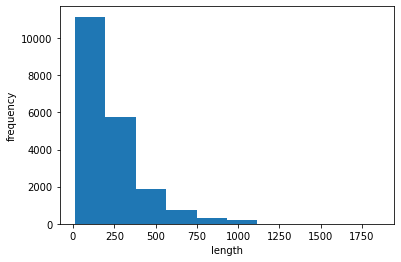

In [27]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

### Sequence Padding
- 전체 자리수를 100으로 가정했을 경우 3개 토큰만 있을 경우 나머지 97개는 비워지고 이를 0으로 채우는 과정

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen = 100)
val_seq = pad_sequences(val_input, maxlen = 100)

In [29]:
# 크기 확인
print(train_seq.shape)

(20000, 100)


> 25000개의 훈련세트중 500개는 검증세트로 빠짐

In [30]:
# 원본의 첫번째 댓글의 마지막 10개 출력 확인
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [31]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


---
# 순환 신경망 모델 만들기

In [32]:
from tensorflow import keras

In [33]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500))) 
# 8: 셀 갯수
# 500: One hot Encoding
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [34]:
# one hot endocing
train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)

(20000, 100, 500)


In [35]:
# one hot encoding 확인하기
print(np.sum(train_oh[0][0])) # 숫자 하나만 나옴

1.0


In [38]:
val_oh = keras.utils.to_categorical(val_seq)
print(val_oh.shape)

(5000, 100, 500)


In [36]:
model.summary()
# 500 * 8 * (8 x 8) + 8 = 4072

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 8)                 4072      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [39]:
rmsprop = keras.optimizers.RMSprop(
  lr=1e-4, # CNN에서의 Optimizer. 0.0001로 설정함
)
model.compile(
  optimizer=rmsprop, 
  loss='binary_crossentropy', # 2진분류라
  metrics=['acc'] # 정확도
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
  'data/best-simple-rnn.h5', 
  save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(
  patience = 3,
  restore_best_weights = True
)

history = model.fit(
  train_oh,
  train_target,
  epochs=100, # RNN에서 제일 작은게 100개
  batch_size=64, # Minibatch 사용 - 100개를 다 경사가항하면 시간이 엄청 걸림. 순환 갯수 8 * 8
  validation_data=(val_oh, val_target),
  callbacks=[checkpoint_cb, early_stopping_cb]
)

/Users/tj/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
313/313 [==============================] - 16s 48ms/step - loss: 0.6952 - acc: 0.5084 - val_loss: 0.6924 - val_acc: 0.5152
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6924 - acc: 0.5172 - val_loss: 0.6917 - val_acc: 0.5188
Epoch 3/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6910 - acc: 0.5224 - val_loss: 0.6910 - val_acc: 0.5182
Epoch 4/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6898 - acc: 0.5332 - val_loss: 0.6902 - val_acc: 0.5274
Epoch 5/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6886 - acc: 0.5394 - val_loss: 0.6896 - val_acc: 0.5300
Epoch 6/100
313/313 [==============================] - 14s 46ms/step - loss: 0.6874 - acc: 0.5454 - val_loss: 0.6891 - val_acc: 0.5346
Epoch 7/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6862 - acc: 0.5501 - val_loss: 0.6883 - val_acc: 0.5362
Epoch 8/100
313/313 [==============================] - 

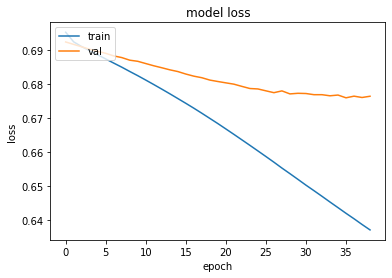

In [40]:
# 시각화 해보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
model.evaluate(val_oh, val_target)

157/157 [==============================] - 3s 16ms/step - loss: 0.6760 - acc: 0.5672


[0.6759989857673645, 0.5672000050544739]

---
## LSTM (Long Short Term Memory) 신경망 모델 구성하기
- 순환신경망의 셀로 이전 타임스탬프의 샘플을 기억하고 있음

In [42]:
model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100)) # 임베딩 층
model.add(keras.layers.LSTM(8)) # LSTM 층
model.add(keras.layers.Dense(1, activation='sigmoid')) # Dense 층

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [43]:
rmsprop = keras.optimizers.RMSprop(
  lr=1e-4, # CNN에서의 Optimizer. 0.0001로 설정함
)
model.compile(
  optimizer=rmsprop, 
  loss='binary_crossentropy', # 2진분류라
  metrics=['acc'] # 정확도
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
  'data/best-simple-lstm.h5', 
  save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(
  patience = 3,
  restore_best_weights = True
)

history = model.fit(
  train_seq,
  train_target,
  epochs=100, # RNN에서 제일 작은게 100개
  batch_size=64, # Minibatch 사용 - 100개를 다 경사가항하면 시간이 엄청 걸림. 순환 갯수 8 * 8
  validation_data=(val_seq, val_target),
  callbacks=[checkpoint_cb, early_stopping_cb]
)

/Users/tj/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
313/313 [==============================] - 17s 38ms/step - loss: 0.6927 - acc: 0.5221 - val_loss: 0.6922 - val_acc: 0.5428
Epoch 2/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6908 - acc: 0.5929 - val_loss: 0.6897 - val_acc: 0.5744
Epoch 3/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6862 - acc: 0.6105 - val_loss: 0.6828 - val_acc: 0.5992
Epoch 4/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6622 - acc: 0.6197 - val_loss: 0.6382 - val_acc: 0.6410
Epoch 5/100
313/313 [==============================] - 11s 35ms/step - loss: 0.6093 - acc: 0.7279 - val_loss: 0.6028 - val_acc: 0.7402
Epoch 6/100
313/313 [==============================] - 11s 36ms/step - loss: 0.5848 - acc: 0.7510 - val_loss: 0.5833 - val_acc: 0.7468
Epoch 7/100
313/313 [==============================] - 11s 34ms/step - loss: 0.5665 - acc: 0.7630 - val_loss: 0.5668 - val_acc: 0.7566
Epoch 8/100
313/313 [==============================] - 

---
## GRU (Gated Recurrent Unit) 신경망 모델 구성하기
- LSTM의 추상화, 간소화된 구성으로 GRU를 사용한다.
- LSTM은 다 좋은데 문장이 길어지면 셀들이 기억하는 것이 너무 길어진다.
- GRU는 셀이 기억하는 것을 줄여준다. - 셀들이 기억하는 갯수를 정해줌
- 드롭아웃을 사용할 필요가 없다.

In [44]:
model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100)) # 임베딩 층
model.add(keras.layers.GRU(8)) 
model.add(keras.layers.Dense(1, activation='sigmoid')) # Dense 층

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(
  lr=1e-4, # CNN에서의 Optimizer. 0.0001로 설정함
)
model.compile(
  optimizer=rmsprop, 
  loss='binary_crossentropy', # 2진분류라
  metrics=['acc'] # 정확도
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
  'data/best-simple-gru.h5', 
  save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(
  patience = 3,
  restore_best_weights = True
)

history = model.fit(
  train_seq,
  train_target,
  epochs=100, # RNN에서 제일 작은게 100개
  batch_size=64, # Minibatch 사용 - 100개를 다 경사가항하면 시간이 엄청 걸림. 순환 갯수 8 * 8
  validation_data=(val_seq, val_target),
  callbacks=[checkpoint_cb, early_stopping_cb]
)